<a href="https://colab.research.google.com/github/colindbrown/methylation-hmm-rnn/blob/master/RNN_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# imports
import torch.nn as nn
import torch 
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import timeit

np.set_printoptions(2)

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# load data
scBSseq = np.load("/content/drive/My Drive/Colab Notebooks/methylation_hmm_rnn/scBSseq.npz")

meth_mat = scBSseq["meth_mat"] # positions x cells matrix of counts of methylated CpGs
unmeth_mat = scBSseq["unmeth_mat"] # positions x cells matrix of counts of unmethylated CpGs (i.e. C got converted to T)
positions = scBSseq["positions"] # genomic position of each CpG
chroms = scBSseq["chroms"] # chromomsome of each CpG
cell_names = scBSseq["cell_names"] # cell type and an arbitrary ID

total_counts = meth_mat + unmeth_mat
ncells_with_reads = (total_counts > 0).sum(1)

In [0]:
# setup data loaders for training, validation, and testing
class CpgDataset(torch.utils.data.Dataset):

    def __init__(self, meth_counts, unmeth_counts, seq_len = 1000):
        super(CpgDataset, self).__init__()
        self.meth_counts = meth_counts
        self.unmeth_counts = unmeth_counts
        self.seq_len = seq_len

    def __getitem__(self, i): 
        return(self.meth_counts[i*self.seq_len:(i+1)*self.seq_len].astype(np.float32), 
               self.unmeth_counts[i*self.seq_len:(i+1)*self.seq_len].astype(np.float32))
            
    def __len__(self):
        return self.meth_counts.shape[0] // self.seq_len

batch_size = 100
seq_len = 1000

hidden_size = 32

training_cpg = chroms == "18"
train_dataset = CpgDataset(meth_mat[training_cpg,:], unmeth_mat[training_cpg,:], seq_len = seq_len)
train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size = batch_size, 
                                               num_workers = 0 )
val_cpg = chroms == "19"
val_dataset = CpgDataset(meth_mat[val_cpg,:], unmeth_mat[val_cpg,:], seq_len = seq_len)
validation_dataloader = torch.utils.data.DataLoader(val_dataset, 
                                               batch_size = batch_size, 
                                               num_workers = 0)
test_cpg = chroms == "17"
test_dataset = CpgDataset(meth_mat[test_cpg,:], unmeth_mat[test_cpg,:], seq_len = seq_len)
test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                               batch_size = batch_size, 
                                               num_workers = 0)

# Implementing a RNN with Memory
Variant on a basic RNN cell that mimics some of the behavior of a GRU, where
$$ f_t = \sigma( W_f [ x_t , h_{t-1} ]^T + \mu_f ) $$
$$ g_t = \tanh( W_g [ x_t , h_{t-1} ]^T + \mu_g ) $$
$$ h_t = f_t \cdot h_{t-1} + (1 - f_t) \cdot g_t $$

In [0]:
# Implementation of an individual RNN Cell with basic memory
class RNNCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNNCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.linearF = nn.Linear(input_size + hidden_size, hidden_size)
        self.linearG = nn.Linear(input_size + hidden_size, hidden_size)
        
    def forward(self, x, h_in):
        """
        Forward computation
        
        Parameters:
        x     - input
                 torch.tensor [batch_size x input_size] 
        h_in  - hidden state from previous time point
                 torch.tensor [batch_size x hidden_size]
            
        Returns:
        h_out - new hidden state 
                  torch.tensor [batch_size x hidden_size]
        """
        combined = torch.cat((x, h_in), 1)
        f = torch.sigmoid( self.linearF(combined) )
        g = torch.tanh( self.linearG(combined) )
        h_out = f * h_in + (1-f) * g
        return h_out

In [0]:
# Implementation of a full RNN Layer
class RNNLayer(nn.Module):
    def __init__(self, rnn_cell):
        super(RNNLayer, self).__init__()
        self.rnn_cell = rnn_cell

    @property
    def hidden_size(self):
        return self.rnn_cell.hidden_size

    @property
    def input_size(self):
        return self.rnn_cell.input_size
        
    def forward(self, x): 
        (seq_len, batch_size, input_size) = x.shape
        hidden = torch.zeros(batch_size, self.hidden_size, device = x.device) # could be an input to the function
        output = torch.zeros(seq_len, batch_size, self.hidden_size, device = x.device)
        for i in range(seq_len): # iterate over sequence
            hidden = self.rnn_cell(x[i,:,:], hidden)
            output[i,:,:] = hidden
        return output

In [0]:
# Model to predict methylation of next position from preceding positions
class MethModel(nn.Module):
    def __init__(self, rnn_layer, input_size = 2, output_size = 1):
        super(MethModel, self).__init__()
        self.hidden_size = rnn_layer.hidden_size
        self.embed = nn.Linear(input_size, rnn_layer.input_size)
        self.rnn_layer = rnn_layer
        self.linear = nn.Linear(self.hidden_size, output_size)

    def forward(self, meth, unmeth):
        batch_size = meth.shape[1]
        num_cells = meth.shape[2]
        meth = meth.view(meth.shape[0], batch_size * num_cells)
        unmeth = unmeth.view(unmeth.shape[0], batch_size * num_cells)
        x = torch.stack((meth,unmeth),2)
        x = self.embed(x)
        x = F.relu(x)
        h = self.rnn_layer(x) 
        if isinstance(rnn_layer, nn.RNNBase): h = h[0]
        output = self.linear(h)
        output = output.view(output.shape[0], batch_size, num_cells, output.shape[-1])
        output = output[:,:,:,0]
        return output

In [0]:
# training methods
def run_one_epoch(train_flag, dataloader, model, optimizer, device="cuda"):

    torch.set_grad_enabled(train_flag)
    model.train() if train_flag else model.eval()

    losses = []
    accuracies = []

    for meth,unmeth in dataloader:
        meth = meth.transpose(0,1).contiguous() 
        unmeth = unmeth.transpose(0,1).contiguous()

        (meth, unmeth) = ( meth.to(device), unmeth.to(device) )

        # forward
        logodds = model(meth, unmeth)

        lo = logodds[:-1,:,:] # shift by one since we're doing one-step ahead prediction
        prob_methylated = torch.sigmoid(lo)

        logProb = torch.log(prob_methylated)
        logCompProb = torch.log(1-prob_methylated)
        loss = - torch.mean(logProb*meth[1:,:,:] + logCompProb*unmeth[1:,:,:])
        
        losses.append(loss.detach().cpu().numpy())

        if train_flag: 
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # calculate accuracy
        meth_sum = meth[1:,:,:] + unmeth[1:,:,:]
        meth_rate = meth[1:,:,:] / meth_sum
        correct = ((meth_rate > .5) == (prob_methylated > .5))[meth_sum > 0]
        accuracy = torch.mean( correct.float() )

        accuracies.append(accuracy.detach().cpu().numpy())  

    return( np.mean(losses), np.mean(accuracies) )

def train_loop(model,
               optimizer,
               train_dataloader, 
               validation_dataloader,
               check_point_filename = '/content/drive/My Drive/scBSseq/rnn_checkpoint.pt',
               max_epochs = 100, 
               patience = 10,
               device = "cuda"):

    train_accs = []
    val_accs = []
    patience_counter = patience
    best_val_loss = np.inf

    for epoch in range(max_epochs):
        start_time = timeit.default_timer()
        train_loss, train_acc = run_one_epoch(True, train_dataloader, model, optimizer, device)
        val_loss, val_acc = run_one_epoch(False, validation_dataloader, model, optimizer, device)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        elapsed = float(timeit.default_timer() - start_time)
        print("Epoch %i took %.2fs. Train loss: %.4f acc: %.4f. Val loss: %.4f acc: %.4f. Patience left: %i" % 
            (epoch+1, elapsed, train_loss, train_acc, val_loss, val_acc, patience_counter ))
        
        if val_loss < best_val_loss: 
            torch.save(model.state_dict(), check_point_filename)
            best_val_loss = val_loss
            patience_counter = patience
        else: 
            patience_counter -= 1
            if patience_counter <= 0: 
                model.load_state_dict(torch.load(check_point_filename)) # recover the best model so far
                break
    
    return(train_accs, val_accs)

In [0]:
# Train RNN and print accuracy
rnn_cell = RNNCell(input_size = hidden_size, hidden_size = hidden_size) 
rnn_layer = RNNLayer(rnn_cell)

model = MethModel(rnn_layer)

device = "cuda"
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), amsgrad=True)

train_accs, val_accs = train_loop(model,
                                optimizer,
                                train_dataloader, 
                                validation_dataloader,
                                check_point_filename = 'rnn_checkpoint.pt',
                                device = device,
                                max_epochs = 30)

test_loss, test_acc = run_one_epoch(False, test_dataloader, model, optimizer, device)
print(test_acc)

Epoch 1 took 10.98s. Train loss: 0.3924 acc: 0.3723. Val loss: 0.4030 acc: 0.3791. Patience left: 10
Epoch 2 took 10.97s. Train loss: 0.3805 acc: 0.4246. Val loss: 0.3897 acc: 0.4700. Patience left: 10
Epoch 3 took 10.99s. Train loss: 0.3695 acc: 0.5112. Val loss: 0.3772 acc: 0.5741. Patience left: 10
Epoch 4 took 10.97s. Train loss: 0.3591 acc: 0.6122. Val loss: 0.3654 acc: 0.6912. Patience left: 10
Epoch 5 took 11.03s. Train loss: 0.3493 acc: 0.7035. Val loss: 0.3541 acc: 0.7863. Patience left: 10
Epoch 6 took 10.98s. Train loss: 0.3401 acc: 0.7700. Val loss: 0.3434 acc: 0.7549. Patience left: 10
Epoch 7 took 10.96s. Train loss: 0.3313 acc: 0.7016. Val loss: 0.3332 acc: 0.7024. Patience left: 10
Epoch 8 took 10.96s. Train loss: 0.3230 acc: 0.6635. Val loss: 0.3235 acc: 0.6927. Patience left: 10
Epoch 9 took 11.00s. Train loss: 0.3152 acc: 0.6567. Val loss: 0.3143 acc: 0.6913. Patience left: 10
Epoch 10 took 10.97s. Train loss: 0.3078 acc: 0.6566. Val loss: 0.3056 acc: 0.6932. Patienc

In [0]:
plt.plot(train_accs,  "--", label="train")
plt.plot(val_accs, label="validation")
plt.axhline(test_acc)
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")

# Comparing RNN Variants
Comparison of MyRNN implementation to PyTorch's built in RNN, GRU, and LSTM layers

In [0]:
# Different model class for torch implementations, as torch layers return a tuple output
class TorchMethModel(nn.Module):
    def __init__(self, rnn_layer, input_size = 2, output_size = 1):
        super(TorchMethModel, self).__init__()
        self.hidden_size = rnn_layer.hidden_size
        self.embed = nn.Linear(input_size, rnn_layer.input_size)
        self.rnn_layer = rnn_layer
        self.linear = nn.Linear(self.hidden_size, output_size)

    def forward(self, meth, unmeth):
        batch_size = meth.shape[1]
        num_cells = meth.shape[2]
        meth = meth.view(meth.shape[0], batch_size * num_cells)
        unmeth = unmeth.view(unmeth.shape[0], batch_size * num_cells)
        x = torch.stack((meth,unmeth),2)
        x = self.embed(x)
        x = F.relu(x)
        # handles extra output from torch implementation
        h, _ = self.rnn_layer(x) 
        if isinstance(rnn_layer, nn.RNNBase): h = h[0]
        output = self.linear(h)
        output = output.view(output.shape[0], batch_size, num_cells, output.shape[-1])
        output = output[:,:,:,0]
        return output

In [0]:
# Training wrapper that runs for multiple provided models
# Plots validation accuracy across training for each
def train_and_plot(models, type, accs):
  for restart, model in enumerate(models):
    print(f'{type} Restart {restart}')

    device = "cuda"
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), amsgrad=True)

    train_accs, val_accs = train_loop(model,
                                optimizer,
                                train_dataloader, 
                                validation_dataloader,
                                check_point_filename = f'{type}_checkpoint_{restart}.pt',
                                device = device,
                                max_epochs = 30)

    test_loss, test_acc = run_one_epoch(False, test_dataloader, model, optimizer, device)
    accs["train"].append(train_accs[-1])
    accs["val"].append(val_accs[-1])
    accs["test"].append(test_acc)
    print(test_acc)

    plt.plot(val_accs, label=f"val accs {restart}")

  plt.legend()
  plt.ylabel('Accuracy')
  plt.title("Validation Accuracy over Training")
  plt.grid(which="both")
  plt.show()

In [0]:
# Training using MyRNN implementation
MyRNN_accs = {"train": [], "val": [], "test": []}
MyRNN_models = []
for i in range(3):
  rnn_cell = RNNCell(input_size = hidden_size, hidden_size = hidden_size) 
  rnn_layer = RNNLayer(rnn_cell)
  MyRNN_models.append(MethModel(rnn_layer))
train_and_plot(MyRNN_models, "MyRNN", MyRNN_accs)

RNN Restart 0
Epoch 1 took 0.53s. Train loss: 0.3708 acc: 0.6414. Val loss: 0.3738 acc: 0.6764. Patience left: 10
Epoch 2 took 0.51s. Train loss: 0.3593 acc: 0.6415. Val loss: 0.3612 acc: 0.6765. Patience left: 10
Epoch 3 took 0.51s. Train loss: 0.3491 acc: 0.6416. Val loss: 0.3500 acc: 0.6766. Patience left: 10
Epoch 4 took 0.50s. Train loss: 0.3402 acc: 0.6418. Val loss: 0.3402 acc: 0.6769. Patience left: 10
Epoch 5 took 0.50s. Train loss: 0.3324 acc: 0.6421. Val loss: 0.3315 acc: 0.6774. Patience left: 10
Epoch 6 took 0.50s. Train loss: 0.3255 acc: 0.6427. Val loss: 0.3238 acc: 0.6780. Patience left: 10
Epoch 7 took 0.50s. Train loss: 0.3192 acc: 0.6436. Val loss: 0.3168 acc: 0.6794. Patience left: 10
Epoch 8 took 0.51s. Train loss: 0.3134 acc: 0.6451. Val loss: 0.3102 acc: 0.6807. Patience left: 10
Epoch 9 took 0.49s. Train loss: 0.3079 acc: 0.6475. Val loss: 0.3039 acc: 0.6843. Patience left: 10
Epoch 10 took 0.49s. Train loss: 0.3024 acc: 0.6504. Val loss: 0.2978 acc: 0.6872. Pat

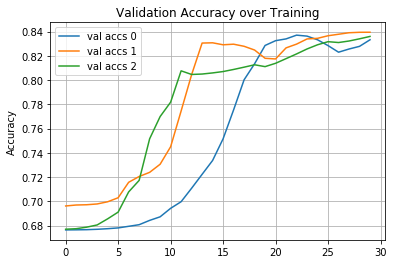

In [0]:
# Training using PyTorch RNN implementation
RNN_accs = {"train": [], "val": [], "test": []}
RNN_models = []
for i in range(3):
  layer = nn.RNN(input_size=hidden_size, hidden_size=hidden_size)
  RNN_models.append(TorchMethModel(layer))
train_and_plot(RNN_models, "RNN", RNN_accs)

In [0]:
# Training using PyTorch GRU implementation
GRU_accs = {"train": [], "val": [], "test": []}
GRU_models = []
for i in range(3):
  layer = nn.GRU(input_size=hidden_size, hidden_size=hidden_size)
  GRU_models.append(TorchMethModel(layer))
train_and_plot(GRU_models, "GRU", GRU_accs)

In [0]:
# Training using PyTorch LSTM implementation
LSTM_accs = {"train": [], "val": [], "test": []}
LSTM_models = []
for i in range(3):
  layer = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size)
  LSTM_models.append(TorchMethModel(layer))
train_and_plot(LSTM_models, "LSTM", LSTM_accs)

In [0]:
# Compare training, validation, and test accuracy for 4 different models on same data
labels = ['MyRNN', 'RNN', 'GRU', 'LSTM']
accs = [MyRNN_accs, RNN_accs, GRU_accs, LSTM_accs]

def plot(acc_type, name):
  x = np.arange(len(labels))
  width = 0.15

  fig, ax = plt.subplots()
  restart1 = ax.bar(x - width, list(map(lambda x: x[acc_type][0],accs)), width, label='Restart 1')
  restart2 = ax.bar(x, list(map(lambda x: x[acc_type][1],accs)), width, label='Restart 2')
  restart3 = ax.bar(x + width, list(map(lambda x: x[acc_type][2],accs)), width, label='Restart 3')

  ax.set_ylabel('Accuracy')
  plt.ylim((.80, .85))   # s
  ax.set_title(name)
  ax.set_xticks(x)
  ax.set_xticklabels(labels)
  ax.legend()

  fig.tight_layout()
  plt.show()  

plot("train", "Training Accuracy for RNN Variants")
plot("val", "Validation Accuracy for RNN Variants")
plot("test", "Test Accuracy for RNN Variants")